In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Explaining text classification with Vertex Explainable AI


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/explainable_ai/xai_text_classification_feature_attributions.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fexplainable_ai%2Fxai_text_classification_feature_attributions.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/explainable_ai/xai_text_classification_feature_attributions.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/explainable_ai/xai_text_classification_feature_attributions.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

## Overview

Vertex Explainable AI offers feature-based and example-based explanations to provide better understanding of model decision making. For feature-based explanations, Vertex Explainable AI integrates feature attributions into Vertex AI. Feature attributions indicate how much each feature in your model contributed to the predictions for each given instance. For a text classification model, when you request explanations, you get the predicted class along with explanations, indicating how much each word or token contributes to the classification.

To use Vertex Explainable AI on a pre-trained or custom-trained model, you must configure certain options when you create the `Model` resource that you plan to request explanations from, when you deploy the model, or when you submit a batch explanation job. This tutorial demonstrates how to configure these options, and get and visualize explanations for text models.

Learn more about [Vertex Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview).

### Objective

In this tutorial, you learn how to configure feature-based explanations using the sampled Shapley method on a TensorFlow text classification model for online predictions with explanations.

This tutorial uses the following Google Cloud ML services and resources:

- `Vertex Explainable AI`
- `Vertex AI Prediction`

The steps performed include:

- Build and train a TensorFlow text classification model
- Upload model for deployment
- Deploy model for online prediction
- Make online prediction with explanations


### Dataset

In this tutorial, you use the [IMDB review sentiment classification dataset](https://keras.io/api/datasets/imdb/) from Keras.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [ ]:
! pip3 install --upgrade -q google-cloud-aiplatform \
                            tensorflow==2.15.1 \
                            matplotlib

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

#### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $LOCATION -p $PROJECT_ID $BUCKET_URI

#### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import libraries

In [ ]:
import warnings

import matplotlib as mpl
import numpy as np
import tensorflow as tf
from IPython.display import HTML
from keras.datasets import imdb
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.utils import pad_sequences

warnings.filterwarnings("ignore")

## Build a TensorFlow model locally

This notebook classifies movie reviews as positive or negative using the text of the review. In this tutorial, you build and train a model in `TensorFlow`.


#### Load IMDB data

In [ ]:
max_features = 10000
maxlen = 80

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

#### Build model

You train an LSTM model in `TensorFlow` on the IMDB sentiment classification task.

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)

print(f"Loss: {loss}  Accuracy: {accuracy}")

#### Export the model

Next, you export the model to your Cloud Storage bucket.

In [ ]:
MODEL_DIR = f"{BUCKET_URI}/model"

tf.saved_model.save(model, MODEL_DIR)

#### Get the serving function signature

You get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer. The input layer name of the serving function is used later when you configure explanation settings.

In [ ]:
saved_model = tf.saved_model.load(MODEL_DIR)
serving_input = list(
    saved_model.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
serving_output = list(
    saved_model.signatures["serving_default"].structured_outputs.keys()
)[0]

print("Serving function input:", serving_input)
print("Serving function output:", serving_output)

## Upload the model for deployment

Next, you upload the model to Vertex AI Model Registry, which creates a Vertex AI model resource for your model.

### Configure explanation settings

To use Vertex Explainable AI with a custom-trained model, you must configure explanation settings when uploading the model. These settings include:

- `parameters`: The feature attribution method. You use the `sampled_shapley_attribution` method in this tutorial.
- `metadata`: The model's input and output for explanation.

Learn more about [configuring feature-based explanations](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations-feature-based).

In [ ]:
PARAMETERS = {"sampled_shapley_attribution": {"path_count": 10}}

parameters = aiplatform.explain.ExplanationParameters(PARAMETERS)

In [ ]:
INPUT_METADATA = {
    "my_input": aiplatform.explain.ExplanationMetadata.InputMetadata(
        {
            "input_tensor_name": serving_input,
            "encoding": aiplatform.explain.ExplanationMetadata.InputMetadata.Encoding(
                1
            ),
        }
    ),
}

OUTPUT_METADATA = {
    "my_output": aiplatform.explain.ExplanationMetadata.OutputMetadata(
        {"output_tensor_name": serving_output}
    )
}

metadata = aiplatform.explain.ExplanationMetadata(
    inputs=INPUT_METADATA, outputs=OUTPUT_METADATA
)

### Upload the model to `Model Registry`

Next, upload your model to `Model Registry` with the explanation configuration. Vertex AI provides [Docker container images](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) that you run as pre-built containers for serving predictions and explanations from trained model artifacts.

In [ ]:
MODEL_DISPLAY_NAME = "tf_text_model_unique"
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest"

uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=MODEL_DIR,
    serving_container_image_uri=DEPLOY_IMAGE,
    explanation_parameters=parameters,
    explanation_metadata=metadata,
)

## Deploy the model for online prediction

Next, deploy your model for online predictions. You set the variable `DEPLOY_COMPUTE` to configure the machine type for the [compute resources](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute) that you use for prediction.

In [ ]:
DEPLOY_DISPLAY_NAME = "tf_text_model_deploy_unique"
DEPLOY_COMPUTE = "n1-standard-4"

endpoint = uploaded_model.deploy(
    deployed_model_display_name=DEPLOY_DISPLAY_NAME,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

## Make online prediction with explanations

You send an `explain` request with encoded input text data to the `endpoint` and get predictions with explanations.


In [ ]:
# Take one example datapoint from the test dataset for prediction
example = x_test[2].tolist()
example_label = y_test[2]

result = endpoint.explain([example])

As you request explanations on a text classification model, you get the predicted class along with an explanation, indicating how much each word or token contributes to the classification.

In [ ]:
prediction = result.predictions[0][0]
attributions = result.explanations[0].attributions[0].feature_attributions["my_input"]

### Visualize explanations

Now, visualize the attributions for the text instance by mapping the values of the attributions onto a matplotlib colormap, as shown below:

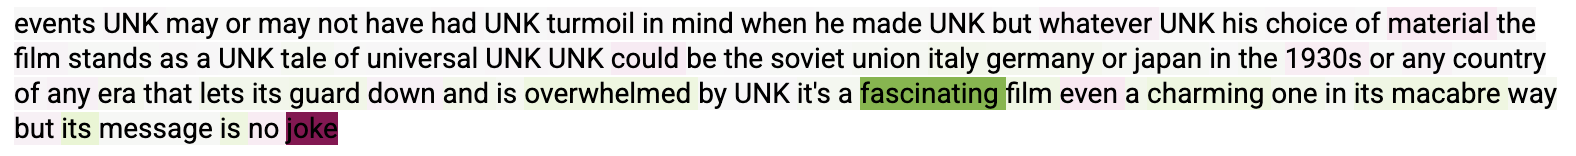


You visualize the attribution values (highlighted in the text) having the highest positive attributions. Words with high positive attribution are highlighted in shades of green and words with negative attribution in shades of pink. Stronger shading corresponds to higher attribution values. Positive attributions can be interpreted as increase in probability of the predicted class while negative attributions correspond to decrease in probability of the predicted class.

In [ ]:
def highlight(string, color="white"):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs, cmap="PiYG"):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.colormaps.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

In [ ]:
index = imdb.get_word_index()
reverse_index = {value: key for (key, value) in index.items()}


def decode_sentence(x, reverse_index):
    # the `-3` offset is due to the special tokens used by keras
    # see https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
    return " ".join([reverse_index.get(i - 3, "UNK") for i in x])

In [ ]:
words = decode_sentence(example, reverse_index).split()
colors = colorize(attributions)

print(f"Prediction:[{prediction}] Actual:[{example_label}]\n")

HTML("".join(list(map(highlight, words, colors))))

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
# Undeploy the model from endpoint
endpoint.undeploy_all()

# Delete the endpoint
endpoint.delete()

# Delete the model
uploaded_model.delete()

# Delete Cloud Storage bucket
delete_bucket = True
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI